In [1]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.0.0
argon2-cffi                  21.1.0
astunparse                   1.6.3
attrs                        21.2.0
backcall                     0.2.0
bleach                       4.1.0
cachetools                   4.2.4
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.7
click                        8.0.3
colorama                     0.4.4
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.0
defusedxml                   0.7.1
entrypoints                  0.3
flatbuffers                  2.0
gast                         0.4.0
google-auth                  2.3.3


You should consider upgrading via the 'E:\lambda\labs\ds-test-2\venv2\Scripts\python.exe -m pip install --upgrade pip' command.


google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.41.1
h5py                         3.5.0
idna                         3.3
ipykernel                    6.5.0
ipython                      7.29.0
ipython-genutils             0.2.0
ipywidgets                   7.6.5
jedi                         0.18.0
Jinja2                       3.0.3
jsonschema                   4.2.1
jupyter                      1.0.0
jupyter-client               7.0.6
jupyter-console              6.4.0
jupyter-core                 4.9.1
jupyterlab-pygments          0.1.2
jupyterlab-widgets           1.0.2
keras                        2.7.0
Keras-Preprocessing          1.1.2
kiwisolver                   1.3.2
libclang                     12.0.0
Markdown                     3.3.4
MarkupSafe                   2.0.1
matplotlib                   3.4.3
matplotlib-inline            0.1.3
mistune                      0.8.4
nbclient                     0.5.8
nbconvert         

This notebook was executed on:
- Windows 10
- Ryzen 3900x
- 32 GB ram
- Nvidia 3080

# Research question:
is it possible using the sythetic dataset provided by generate.py and samples of user input provided by story_photo_transformer.py to generate coordinates with less than 8pix mean average error.

---

## Hypothesis
Slicing the image into slices of 1/3 and only giving the model the corners will lower MAE of the baseline.

In [2]:
#shared experiment variables
global_batch_size = 96
global_epochs = 1000
global_learning_rate =.00015

In [3]:
# this allows tensorflow to find my local cuda installation, remove this or change it to match your environment

#%set_env CUDA_PATH=e:\cuda\bin
#%set_env CUDA_PATH_V11_2=e:\cuda\bin
#%set_env PATH=%PATH%;e:\cuda\bin;e:\cuda\extras;e:\cuda\include;e:\cuda\lib

import os
os.add_dll_directory(r'e:\cuda\bin')

import json
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import glob

# graphing function
def display_history(hist):
    # plot history

    loss_p = hist.history['loss']
    val_loss_p = hist.history['val_loss']

    plt.figure(figsize=(15,5))
    plt.plot(loss_p, label='MAE (training data)')
    plt.title('MAE for points')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()

    plt.figure(figsize=(15,5))
    plt.plot(val_loss_p, label='MAE (validation data)')
    plt.title('MAE for points')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    #plt.yscale('log',base=2)
    plt.show()

class GetCorners(tf.keras.layers.Layer):

    def __init__(self,divisions:int=3):
        super(GetCorners, self).__init__()
        self.divisions=divisions

    def call(self, inputs):
        h = inputs.shape[1]
        w = inputs.shape[2]
        h_seg = int(h/self.divisions)
        w_seg = int(w/self.divisions)
        h_mid = int(h - h_seg)
        w_mid = int(w - w_seg)

        first = (h_seg,w_seg)
        middle = (h_mid,w_mid)

        corner1 = inputs[...,:first[0] ,:first[1]   ,:]
        corner2 = inputs[...,middle[0]:,:first[1]  ,:]
        corner3 = inputs[...,middle[0]:,middle[1]: ,:]
        corner4 = inputs[...,:first[0], middle[1]: ,:]
        out1 = tf.concat([corner1,corner2],1)
        out2 = tf.concat([corner4,corner3],1)
        out3 = tf.concat([out1,out2],2)
        return out3

In [4]:

# this is the path to the synthetic data generated by generate.py, you may need to change this to match your system.
data_dir =r'..\..\..\models\synthetic_data\synthetic_data_for_pipeline_transform\data\*\*'
example_data_files = glob.glob(data_dir)[0:]
print(f'Example of data {example_data_files[0:3]}, {len(example_data_files)} records')

# load each of the X_input files using opencv and convert to BGR colorspace as required by opencv
X_train =[ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in example_data_files if "X_input" in x ]
# load point data for each record
y_train =[ json.loads( open(y,'rb').read() )["y_label_points"] for y in example_data_files if ".json" in y ]

# convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train).reshape((X_train.shape[0],8))

# load real data
# this loads actual recorded user data that optimally we would like to predict with zero error.

path_real = r'..\..\..\data\transcribed_stories\*\*\phase0\*'
real_set=glob.glob(path_real)
# load and convert the data
X_real =np.array([ cv2.cvtColor(cv2.imread(x),cv2.COLOR_RGB2BGR) for x in real_set if "X_input" in x ])
y_real =[ json.loads(open(y,'rb').read() )["y_label_points"] for y in real_set if ".json" in y ]
y_real = np.array(y_real).reshape((X_real.shape[0],8))

assert (X_real.shape[0]==y_real.shape[0])
print(f'Sythetic  data contains {X_train.shape[0]} records.')
print(f'Real data contains {X_real.shape[0]} records.')

Example of data ['..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.json', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.X_input.png', '..\\..\\..\\models\\synthetic_data\\synthetic_data_for_pipeline_transform\\data\\10\\007880cf-c97e-425d-9577-96318042598d.y_label.png'], 22170 records
Sythetic  data contains 7390 records.
Real data contains 3 records.


In [5]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs

# Simple grayscale

corners=GetCorners(divisions=3)(x)

x = layers.Flatten()(corners)

x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 get_corners (GetCorners)    (None, 170, 128, 3)       0         
                                                                 
 flatten (Flatten)           (None, 65280)             0         
                                                                 
 dense (Dense)               (None, 32)                2088992   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 8)                 264

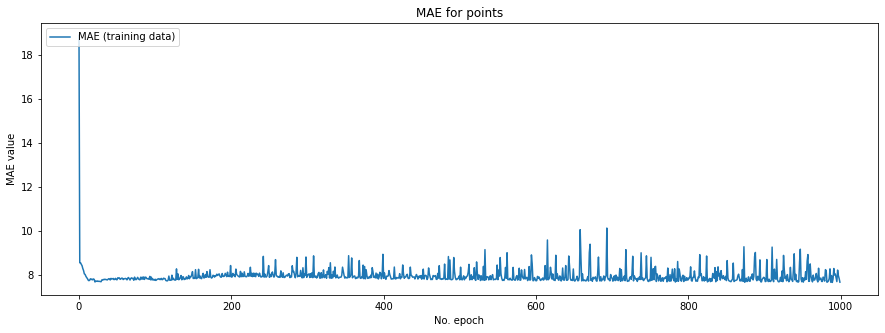

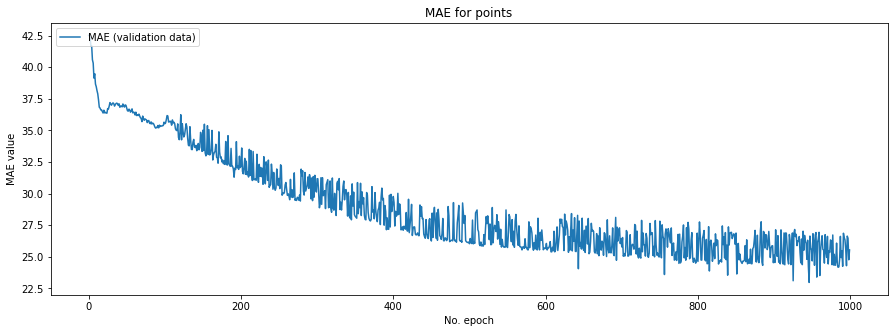

The minimum MAE achieved by the training was 7.6425933837890625.
The minimum MAE achieved on the real data was 22.97004508972168.
runtime: 641.1639695167542 seconds


In [6]:
start = time.time()
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')
print(f'runtime: {time.time()-start} seconds')

In [7]:
# uncomment this to see a proof of the slicing teqnique
# intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=model.layers[1].output)
# sliced=intermediate_model.predict(X_train[0].reshape(1,256,192,3))
# print(sliced.mean())
# plt.imshow(sliced.reshape(sliced.shape[1],sliced.shape[2],sliced.shape[3]).astype("uint8"))
# plt.show()
#
# plt.imshow(X_train[0])
# plt.show()

In [8]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs

# Simple grayscale

corners=GetCorners(divisions=4)(x)

x = layers.Flatten()(corners)

x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 get_corners_1 (GetCorners)  (None, 128, 96, 3)        0         
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                1179680   
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 8)                 264

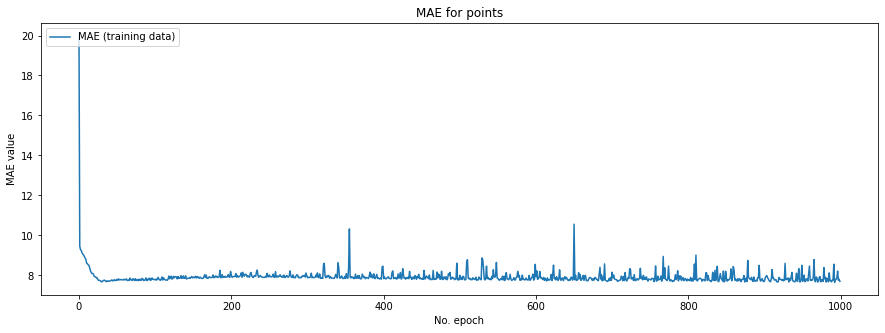

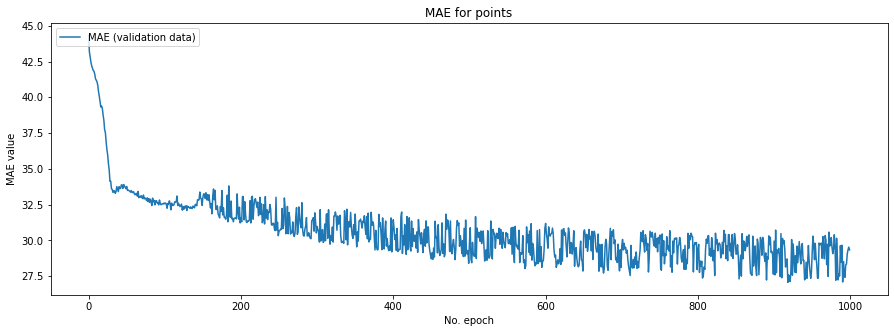

The minimum MAE achieved by the training was 7.645534038543701.
The minimum MAE achieved on the real data was 27.062637329101562.
runtime: 671.1397631168365 seconds


In [9]:
start = time.time()
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')
print(f'runtime: {time.time()-start} seconds')

In [10]:
c_init = keras.initializers.Constant(.004)
b_init = keras.initializers.Constant(.004)

img_inputs = keras.Input(shape=(256, 256-64, 3))
x = img_inputs

# Simple grayscale

corners=GetCorners(divisions=5)(x)

x = layers.Flatten()(corners)

x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)
x = layers.Dense(32, activation="relu",dtype="float32",kernel_initializer=c_init,bias_initializer=b_init)(x)

outputs = layers.Dense(8,activation="relu",kernel_initializer=c_init,bias_initializer=b_init)(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="FC_Model")
model.summary()
model.compile(loss="MAE",optimizer=tf.keras.optimizers.Adam(learning_rate=global_learning_rate))

Model: "FC_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 get_corners_2 (GetCorners)  (None, 102, 76, 3)        0         
                                                                 
 flatten_2 (Flatten)         (None, 23256)             0         
                                                                 
 dense_8 (Dense)             (None, 32)                744224    
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 8)                 264

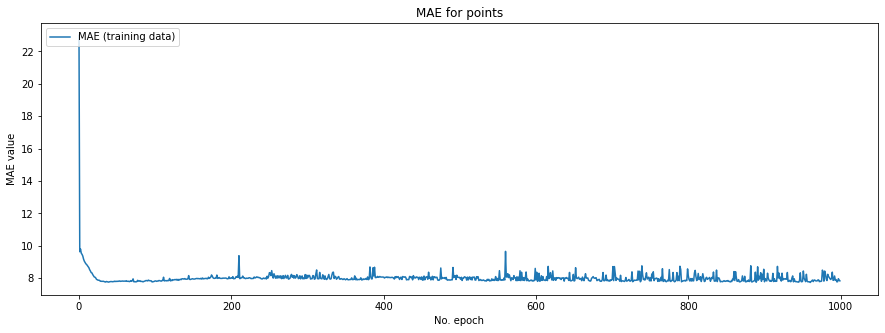

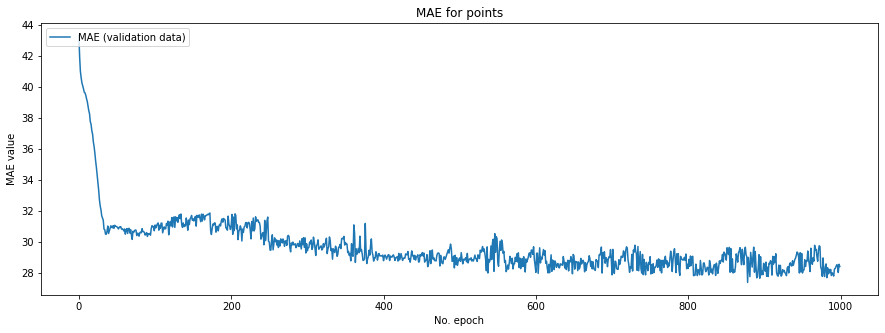

The minimum MAE achieved by the training was 7.730838775634766.
The minimum MAE achieved on the real data was 27.369775772094727.
runtime: 793.3310775756836 seconds


In [11]:
start = time.time()
tests=[]
for test in range(1):
    with tf.device("GPU"):
        history = model.fit(X_train,y_train,epochs=global_epochs,validation_data=(X_real,y_real),shuffle=False,verbose=0,
                            batch_size=global_batch_size)
        tests.append(history)


display_history(history)

min_loss = np.array(history.history['loss']).min()
min_val = np.array(history.history['val_loss']).min()
print(f'The minimum MAE achieved by the training was {min_loss}.')
print(f'The minimum MAE achieved on the real data was {min_val}.')
print(f'runtime: {time.time()-start} seconds')

